# System Threat Forcaster - MLP Project

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import lightgbm as lgb

from scipy.stats import chi2_contingency, t, gaussian_kde, zscore

## Loading Datasets

In [2]:
# Load the datasets
train_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv") 
X_test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")   

In [3]:
train_df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [4]:
# Print shapes of train and test datasets
print("Train Shape:", train_df.shape)
print("Test Shape:", X_test.shape)

# Separate features (X_train) and target variable (y_train)
X_train = train_df.drop(columns=["target"]) 
y_train = train_df["target"] 

# Print shapes of X_train and y_train
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

Train Shape: (100000, 76)
Test Shape: (10000, 75)
X_train Shape: (100000, 75)
y_train Shape: (100000,)


## Data Analysis and Data Corrections

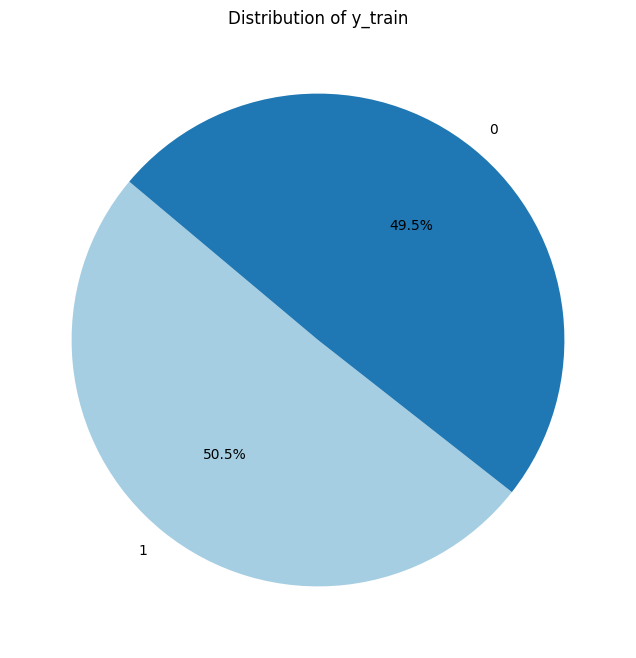

In [5]:
value_counts = y_train.value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of y_train")
plt.show()

In terms of the target values, the dataset seems balanced with nearly equal number of samples for each class.

Certain errors can be spotted from the dataset:
1. Incorrect spelling of **Upgrade**.
2. Presence of **UNKNOWN** and **Unknown** in the columns.

Each of these is handled below :

In [6]:
X_train.replace({'UUPUpgrade': 'Upgrade', 'Unknown': np.nan, 'UNKNOWN': np.nan}, inplace=True)
X_test.replace({'UUPUpgrade': 'Upgrade', 'Unknown': np.nan, 'UNKNOWN': np.nan}, inplace=True)

Extracting features like **Date**, **Month**, **Year**, **Hour** and **Minute** from the datetime type columns to assess each feature individually. 

In [7]:
# Convert 'DateAS' to datetime format in X_train and X_test
X_train['DateAS'] = pd.to_datetime(X_train['DateAS'])
X_test['DateAS'] = pd.to_datetime(X_test['DateAS'])

# Convert 'DateOS' to datetime format in X_train and X_test
X_train['DateOS'] = pd.to_datetime(X_train['DateOS'])
X_test['DateOS'] = pd.to_datetime(X_test['DateOS'])

for df in [X_train, X_test]:
    # Extract components from 'DateAS'
    df['DateAS_Date'] = df['DateAS'].dt.day
    df['DateAS_Month'] = df['DateAS'].dt.month
    df['DateAS_Year'] = df['DateAS'].dt.year
    df['DateAS_Hour'] = df['DateAS'].dt.hour
    df['DateAS_Minute'] = df['DateAS'].dt.minute

    # Extract components from 'DateOS'
    df['DateOS_Date'] = df['DateOS'].dt.day
    df['DateOS_Month'] = df['DateOS'].dt.month
    df['DateOS_Year'] = df['DateOS'].dt.year

# Drop original columns from both datasets
X_train.drop(columns=['DateAS', 'DateOS'], inplace=True)
X_test.drop(columns=['DateAS', 'DateOS'], inplace=True)

### Checking for Nan values

In [8]:
# Print the number of Nan values in each column
Nan_values = X_train.isna().sum()
Nan_values[Nan_values > 0]

RealTimeProtectionState                  66
AntivirusConfigID                        76
NumAntivirusProductsInstalled            76
NumAntivirusProductsEnabled              76
CityID                                  623
IsSystemProtected                        76
SMode                                   981
IEVersionID                             107
FirewallEnabled                         166
EnableLUA                                19
OEMNameID                               212
OEMModelID                              228
ProcessorCoreCount                       85
ProcessorManufacturerID                  85
ProcessorModelID                         85
PrimaryDiskCapacityMB                   110
PrimaryDiskType                        3128
SystemVolumeCapacityMB                  110
TotalPhysicalRAMMB                      151
ChassisType                             515
PrimaryDisplayDiagonalInches             72
PrimaryDisplayResolutionHorizontal       72
PrimaryDisplayResolutionVertical

### Imputations

The data can't be directly processed due to presence of Nan values. So, imputers are being used to fill in the missing values in the dataset. 
A very large numer of variables are categorical. To impute such variables, `SimpleImputer` with the `most_frequent` strategy is being utilized. The numerical variables are being imputed using the `median` strategy of `SimpleImputer`.

In [9]:
def basic_imputation(train_df, test_df = None):
    X_train = train_df.copy()
    if test_df is not None:
        X_test = test_df.copy()
        
    # List of all columns in dataset
    dataset_columns = X_train.columns
    
    # Since most columns contain fixed categories, I am using modal imputation on a majority of columns
    modal_imputed_columns = dataset_columns.drop(['PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical'])
    
    # Modal imputation (Most Frequent)
    modal_imputer = SimpleImputer(strategy='most_frequent')
    X_train[modal_imputed_columns] = modal_imputer.fit_transform(X_train[modal_imputed_columns])
    if test_df is not None : X_test[modal_imputed_columns] = modal_imputer.transform(X_test[modal_imputed_columns])
    
    # Median imputation for selected columns
    median_imputed_columns = ['PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical']
    median_imputer = SimpleImputer(strategy='median')
    X_train[median_imputed_columns] = median_imputer.fit_transform(X_train[median_imputed_columns])
    if test_df is not None: X_test[median_imputed_columns] = median_imputer.transform(X_test[median_imputed_columns])

    if test_df is not None:
        return X_train, X_test
    else:
        return X_train

In [10]:
X_train, X_test = basic_imputation(X_train, X_test)

### Box-Plots for detecting outliers
These plots are useful to observe the distribution of data in terms of percentiles, and observing the outliers in the data.

In [11]:
# Selecting relevant columns
selected_columns = ['CountryID', 'CityID', 'GeoRegionID', 'OEMNameID', 'OEMModelID', 'ProcessorModelID', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'FirmwareVersionID', 'PrimaryDisplayResolutionVertical', 'DateAS_Date', 'DateAS_Hour', 'DateAS_Minute', 'PrimaryDiskCapacityMB', 'LocaleEnglishNameID', 'InternalBatteryNumberOfCharges', 'ProcessorCoreCount', 'IEVersionID', 'TotalPhysicalRAMMB', 'OSInstallLanguageID', 'FirmwareManufacturerID']

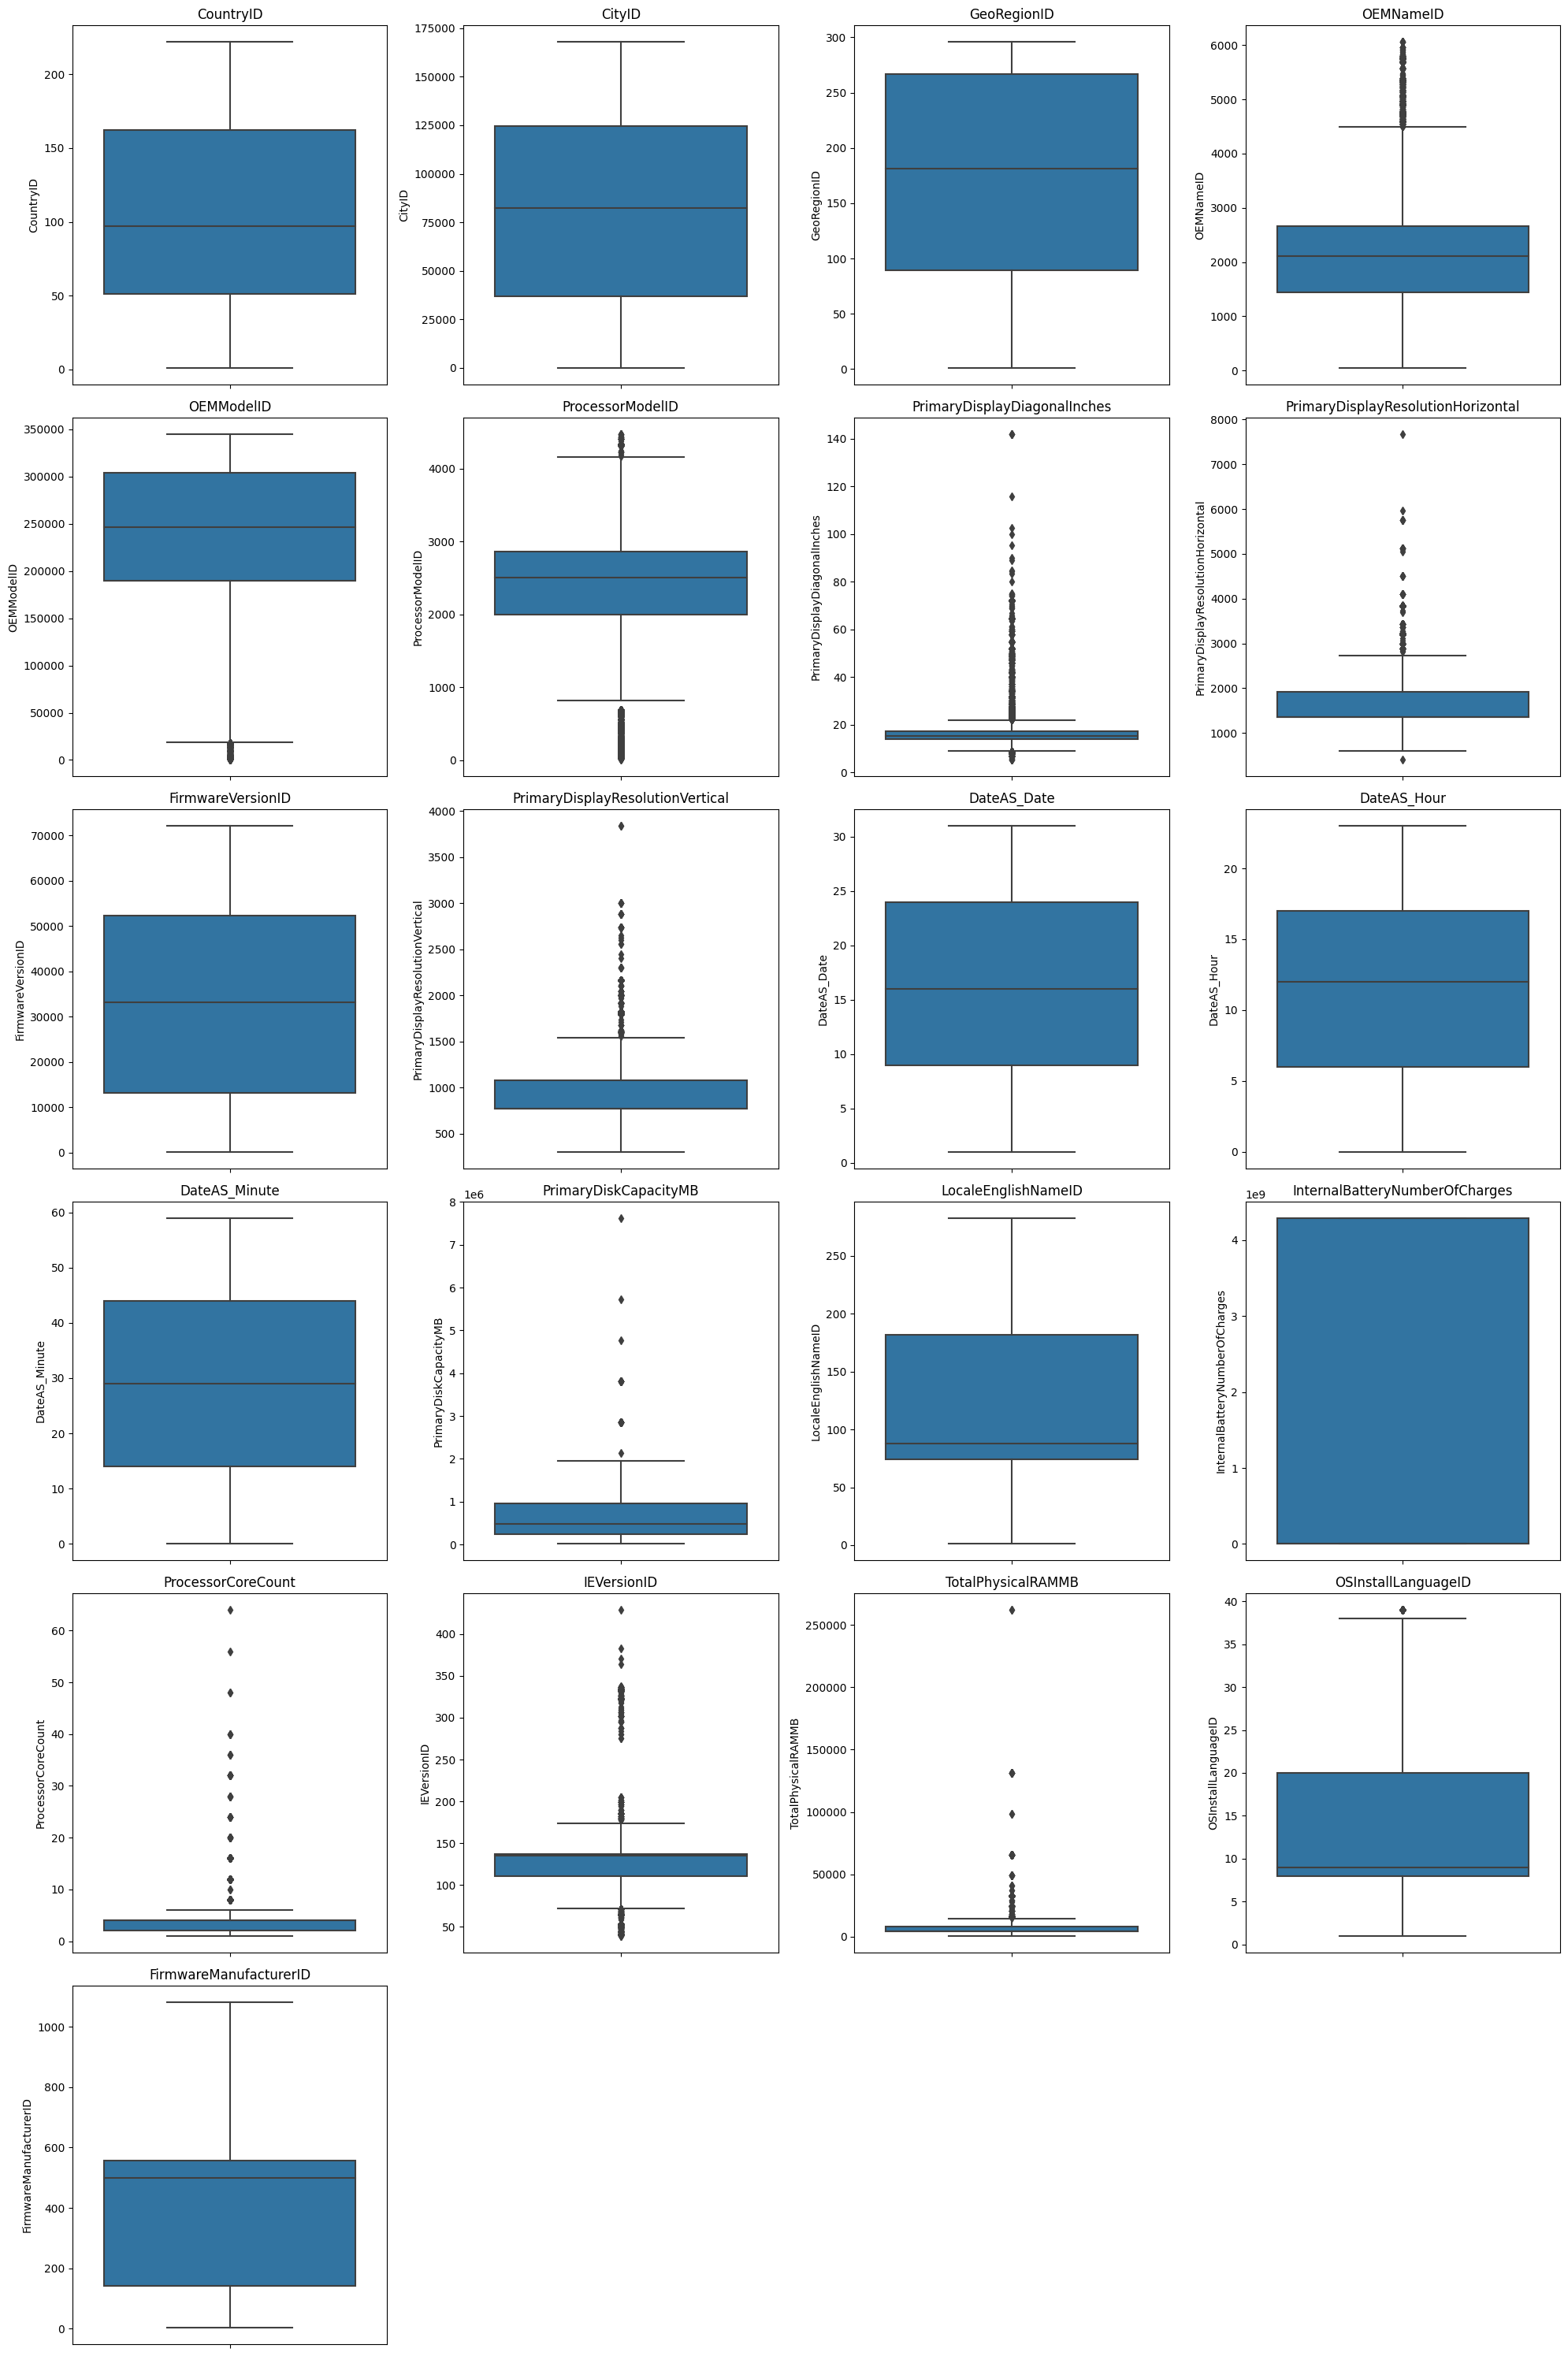

In [12]:
# Define number of rows and columns for subplots
num_cols = len(selected_columns)
rows = (num_cols // 4) + (num_cols % 4 > 0)

# Create subplots
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()

# Plot each column separately
for i, col in enumerate(selected_columns):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Outliers can be observed as small bubbles outside of the boxes in the box plot. These outliers often tend to reduce the trainig efficiency, and hence need to be removed.

To handle the outliers, the **Inter-Quartile Range (IQR)** is being used here.

In [13]:
def replace_outliers_with_nan(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with NaN
        df[col] = df[col].mask((df[col] < lower_bound) | (df[col] > upper_bound), np.nan)
    
    return df

X_train = replace_outliers_with_nan(X_train, selected_columns)
y_train = y_train.loc[X_train.index]
X_train.shape

(100000, 81)

In [14]:
X_train = basic_imputation(X_train)
X_train

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsGamer,RegionIdentifier,DateAS_Date,DateAS_Month,DateAS_Year,DateAS_Hour,DateAS_Minute,DateOS_Date,DateOS_Month,DateOS_Year
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0.0,6.0,10,9,2018,10,11,17.0,4.0,2018.0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,0.0,10.0,16,8,2018,0,1,14.0,8.0,2018.0
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,1.0,6.0,20,9,2018,23,20,11.0,9.0,2018.0
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,0.0,12.0,14,9,2018,0,32,3.0,1.0,2018.0
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,1.0,7.0,15,9,2018,19,34,11.0,9.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,a378b2196a7a1d8ee0d4f989ee46730e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1582.0,0,7.0,0,68585.0,2.0,...,1.0,7.0,21,9,2018,0,59,20.0,9.0,2018.0
99996,7f4433ca05d24b9bbdd3932f8b05e61f,win8defender,1.1.15100.1,4.18.1806.18062,1.273.1156.0,0,7.0,0,11280.0,2.0,...,0.0,3.0,10,8,2018,7,23,10.0,7.0,2018.0
99997,d6852dfff534e03d5ddfd3c7875ab072,win8defender,1.1.15200.1,4.18.1807.18075,1.275.209.0,0,7.0,0,53447.0,1.0,...,1.0,1.0,26,8,2018,23,51,13.0,3.0,2018.0
99998,70a8dc682128c9ff78a3de5aea9dac74,win8defender,1.1.14901.4,4.16.17656.18052,1.269.641.0,0,7.0,0,53447.0,1.0,...,0.0,1.0,4,6,2018,17,13,8.0,5.0,2018.0


### Basic filtering of columns

In [15]:
# Get the number of unique values per column
unique_categories = X_train.nunique()

# Select columns that have only one unique category
single_category_cols = unique_categories[unique_categories == 1].index
single_category_cols

Index(['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled'], dtype='object')

These columns donot vary throughout the dataset, and therefore donot contribute towards the prediction. So, they may be removed.

In [16]:
X_train.drop(columns = single_category_cols, inplace = True)
X_test.drop(columns = single_category_cols, inplace = True)

In [17]:
# Sort in descending order and take the top 5
top_5_unique_cols = unique_categories.sort_values(ascending=False).head(5)
top_5_unique_cols

MachineID                 99835
SystemVolumeCapacityMB    46188
CityID                    16047
OEMModelID                15530
FirmwareVersionID         12299
dtype: int64

**MachineID** almost has as many unique values as the number of data samples. Since this parameter acts as a key, and is unqiue for each data sample, with no visible relation betweeen the different values of this feature, it may be removed from the set of features.

In [18]:
X_train.drop(columns = ["MachineID"], inplace = True)
X_test.drop(columns = ["MachineID"], inplace = True)

### Basic Preprocessing

In [19]:
# Separate the columns containing non-numeric values
categorical_columns = ['ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DeviceFamily']
numeric_columns = X_train.columns.drop(categorical_columns)

# Make sure the numeric columns have numeric datatypes
X_train[numeric_columns] = X_train[numeric_columns].apply(pd.to_numeric, errors='raise')

### Checking for Gaussian Distribution

In [20]:
def plot_histograms(X_train, selected_columns):
    # Create the figure
    fig, axes = plt.subplots(len(selected_columns), 1, figsize=(12, len(selected_columns) * 3))
    
    # Loop through selected features
    for i, feature in enumerate(selected_columns):
        ax = axes[i]  # Get the current axis
        
        # Plot histogram
        counts, bins, _ = ax.hist(X_train[feature], bins=30, density=True, alpha=0.5, color='royalblue', edgecolor='black')
        
        # Compute KDE
        kde = gaussian_kde(X_train[feature].dropna())  # Drop NaN values if any
        x_grid = np.linspace(bins[0], bins[-1], 100)
        ax.plot(x_grid, kde(x_grid), color='red', lw=2.5, label="KDE")
    
        # Titles and labels
        ax.set_title(f'Distribution of {feature}', fontsize=12, fontweight='bold', color='darkblue')
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
    
        # Grid for better readability
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Add legend
        ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

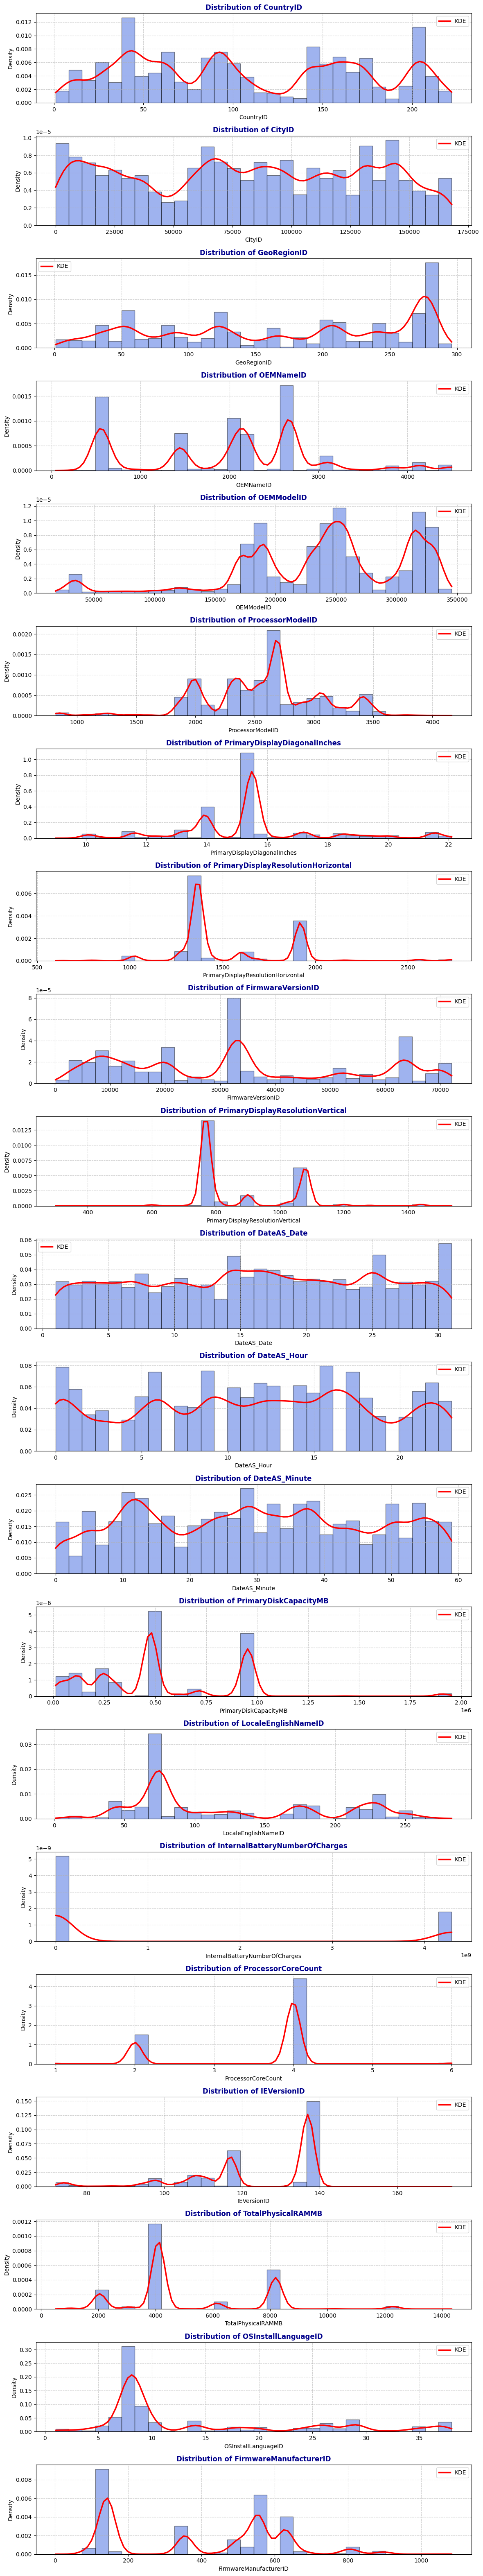

In [21]:
plot_histograms(X_train, selected_columns)

### Applying transformations via Pipeline
As we had seen from the histograms that some features show plots which match the gaussian or mixed guassian kind of distributions. To enhance this distribution, two transformation techniques are being applied based on the **skew** of the feature.

**Skew** : This is a statistical measure of the assymetry in distribution of values.

Based on skew, two transformation techniques being used are:
1. Log Transformation : Scales down each data value to its logarithm. Used when **$|skew| > 1$**
2. Yeo Johnson Transformation : A power based transformation used when **$1 > |skew| > 0.5$**

Both the transformations help in:
* Reducing the assymmetry by compressing the tale, thus bringing the data closer to normal distribution
* Reduces the impact of outliers

Both of the above feature are known to enahnce the model training.

In [22]:
log_transform_cols = []
power_transform_cols = []

for col in selected_columns:
    # Checking skewness of each selected column
    skew = X_train[col].skew()
    if abs(skew) > 1:
        print(f'{col} : Log Transform') # Log transformation if |skewness| > 1 
        log_transform_cols.append(col)
    elif abs(skew) > 0.5:
        print(f'{col} : Yeo-Johnson Transform') # Yeo-johnson transformation if 1 > |skewness| > 0.5
        power_transform_cols.append(col)

OEMModelID : Yeo-Johnson Transform
PrimaryDisplayDiagonalInches : Yeo-Johnson Transform
PrimaryDisplayResolutionHorizontal : Log Transform
PrimaryDisplayResolutionVertical : Log Transform
PrimaryDiskCapacityMB : Yeo-Johnson Transform
LocaleEnglishNameID : Yeo-Johnson Transform
InternalBatteryNumberOfCharges : Log Transform
ProcessorCoreCount : Yeo-Johnson Transform
IEVersionID : Log Transform
TotalPhysicalRAMMB : Yeo-Johnson Transform
OSInstallLanguageID : Log Transform


In [23]:
# Log transformation using FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Power transformation using Yeo-Johnson
power_transformer = PowerTransformer(method='yeo-johnson')

num_pipeline = ColumnTransformer([
    ('log', log_transformer, log_transform_cols),
    ('power', power_transformer, power_transform_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ('transformations', num_pipeline),
    ('standard_scaling', StandardScaler())
])
# Fit and transform on training data
X_train_transformed = pipeline.fit_transform(X_train[selected_columns])

# Transform test data
X_test_transformed = pipeline.transform(X_test[selected_columns])

# Get all column names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=selected_columns, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=selected_columns, index=X_test.index)

# Convert back to DataFrame
X_train = pd.concat([X_train.drop(columns=selected_columns), X_train_transformed_df], axis=1)
X_test = pd.concat([X_test.drop(columns=selected_columns), X_test_transformed_df], axis=1)

### Correlation

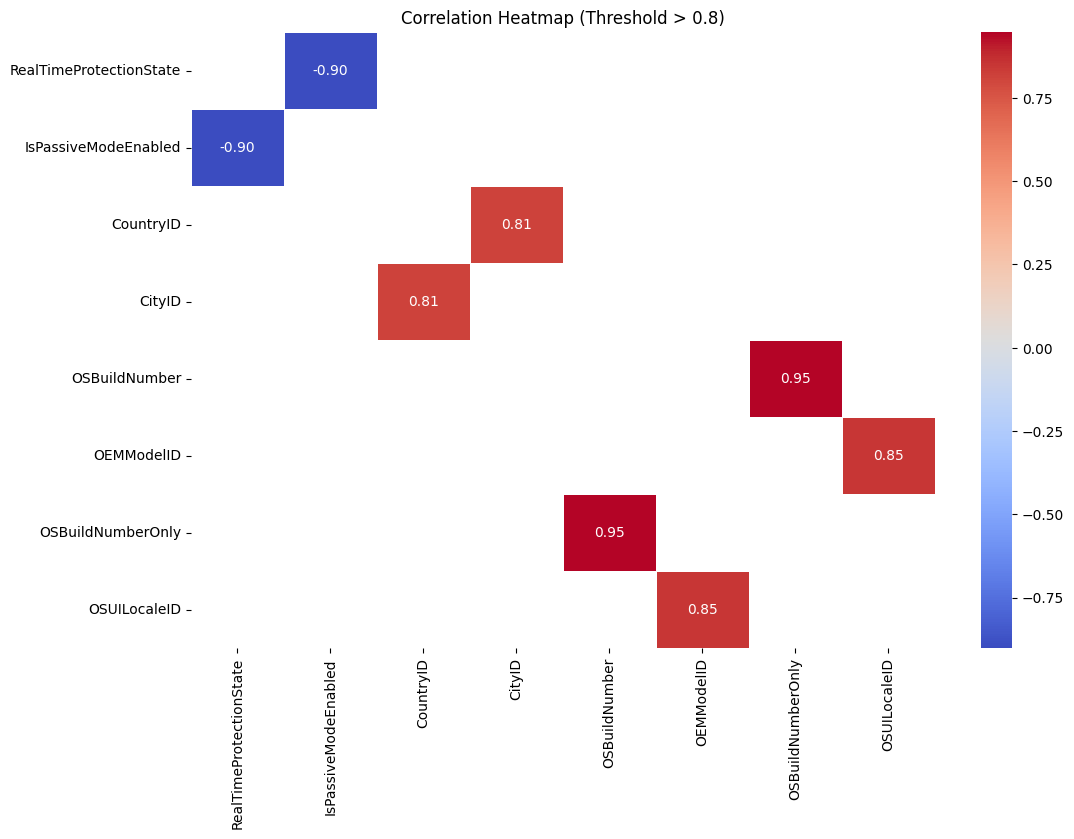

In [24]:
# Defining the correlation threshold
threshold = 0.8

# Computing the correlation matrix for numeric columns
correlation_matrix = X_train[numeric_columns].corr()

# Filtering correlations above the threshold
filtered_corr = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)]

# Dropping rows and columns that are entirely NaN
filtered_corr = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)
filtered_corr = filtered_corr.fillna(0)

# Creating a mask for zero values
mask = filtered_corr == 0

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, mask = mask)
plt.title(f'Correlation Heatmap (Threshold > {threshold})')
plt.show()

The highly correlated pairs donot add significant information for model traning. So, we may filter the features to ensure each feature has some importance.

In [25]:
X_train.drop(columns = ['RealTimeProtectionState', 'CountryID', 'OSBuildNumber', 'OSUILocaleID'], inplace = True)
X_test.drop(columns = ['RealTimeProtectionState', 'CountryID', 'OSBuildNumber', 'OSUILocaleID'], inplace = True)

In [26]:
numeric_columns = numeric_columns.drop(['RealTimeProtectionState', 'CountryID', 'OSBuildNumber', 'OSUILocaleID'])

### Categroical Columns

#### Bar Charts

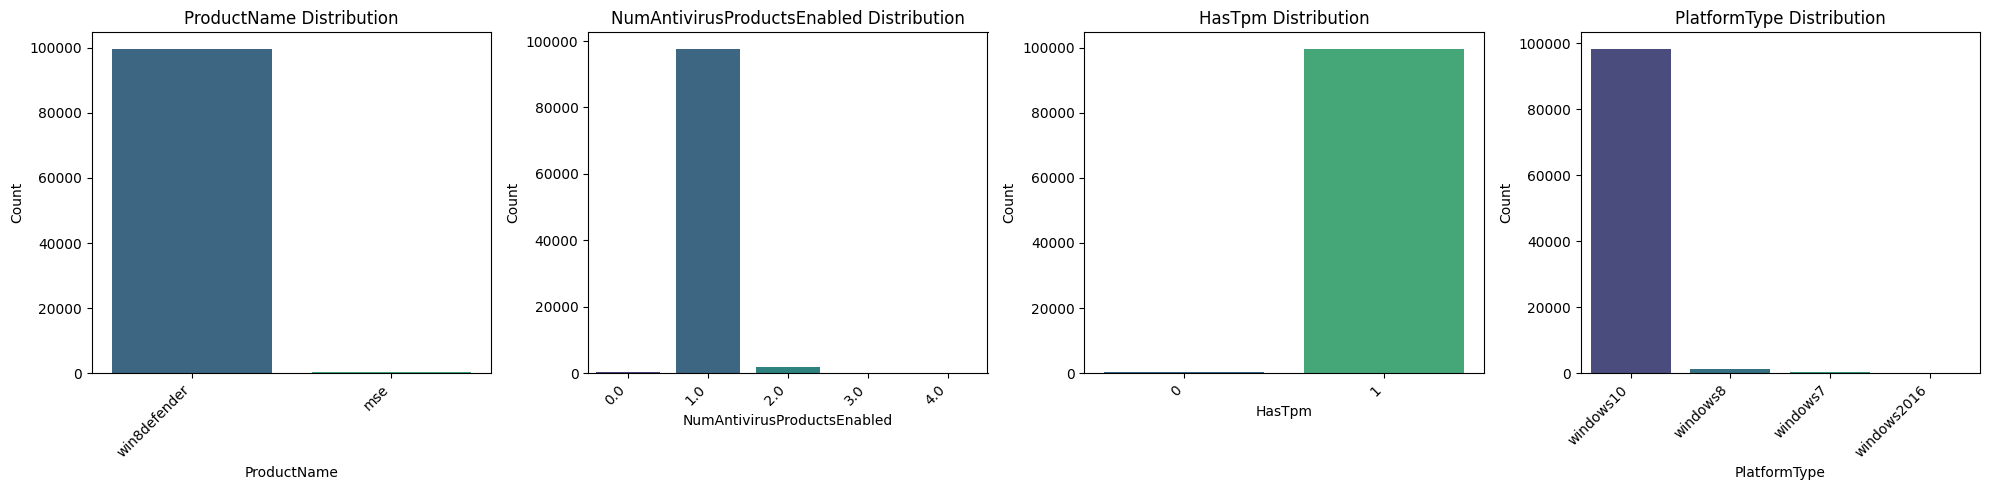

In [27]:
columns = ['ProductName', 'NumAntivirusProductsEnabled', 'HasTpm', 'PlatformType']
fig, axes = plt.subplots(1, len(columns), figsize=(20, 5))

for i, col in enumerate(columns):
    counts = X_train[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette='viridis')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

The above bar-chart shows that the `ProductName` feature in train data has vast majority of a single category *win8defender*. Similarly in other cases as well, a single category dominates. Such columns donont contribute much to the classification output due to very low variance.

### Statistical Significance

In [28]:
# Create a dictionary to store p-values
chi2_results = {}

# Iterating over all categorical columns
for col in categorical_columns:
    contingency_table = pd.crosstab(X_train[col], y_train)  # Create a frequency table

    # Performing Chi-Square test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    
    if p_value > 0.05:
        chi2_results[col] = p_value  # Store p-value

# Converting to a DataFrame for better visualization
chi2_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'P-Value'])

# Sorting by significance
chi2_df.sort_values(by="P-Value", inplace=True)

# Displaying results
chi2_df

,Feature,P-Value
2,OSGenuineState,0.051006
0,ProductName,0.138258
1,OSVersion,0.257333
3,FlightRing,0.486370


Chi-squared test shows that the above columns are independent from the target. This means any variation in these columns doesn't affect the target variable. So we may drop these columns.

In [29]:
X_train.drop(columns = [key for key in chi2_results.keys()], inplace = True)
X_test.drop(columns = [key for key in chi2_results.keys()], inplace = True)

### Linearity Check

In [30]:
def get_p_value_sklearn(X, y):

    model = LinearRegression()
    model.fit(X, y)  # Fit the model

    # Get predictions and residuals
    y_pred = model.predict(X)
    residuals = y - y_pred

    # Compute standard error of coefficients
    n = len(y)
    p = 1  # Only one feature at a time
    mse = np.sum(residuals**2) / (n - p - 1)  # Mean squared error
    var_x = np.var(X, ddof=1)  # Variance of X
    se_beta = np.sqrt(mse / (n * var_x))  # Standard error of coefficient

    # Compute t-statistic
    beta = model.coef_[0]  # Coefficient of the feature
    t_stat = beta / se_beta

    # Compute p-value using t-distribution
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=n - p - 1))

    return p_value

In [31]:
# Dictionary to store p-values
p_values = {}

# Iterating over all numeric columns
for col in numeric_columns:
    p_value = get_p_value_sklearn(X_train[col].values.reshape(-1,1), y_train)

    # Store only if p-value > 0.05 (not significantly related)
    if p_value > 0.05:
        p_values[col] = p_value

# Converting to DataFrame for better visualization
independent_numerical_features = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-Value'])

# Sorting by p-value
independent_numerical_features.sort_values(by="P-Value", inplace=True)

# Displaying results
independent_numerical_features

,Feature,P-Value
6,OSInstallLanguageID,0.121163
8,DateAS_Hour,0.144336
9,DateAS_Minute,0.156435
2,ProcessorCoreCount,0.191398
3,ProcessorManufacturerID,0.331552
5,PrimaryDiskCapacityMB,0.375639
7,IsSecureBootEnabled,0.508526
1,OEMModelID,0.529101
0,EnableLUA,0.542129
4,ProcessorModelID,0.628218


### Polynomial Features

In [32]:
def polynomial_feature_selection(X_train, X_test, numeric_features, degree=2):

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly.fit_transform(X_train[numeric_features])  # Transform selected features
    X_poly_test = poly.transform(X_test[numeric_features])  # Transform test features

    # Extracting new feature names
    feature_names = poly.get_feature_names_out(numeric_features)

    # Dictionary to store p-values of significant features
    significant_poly_features = {}
    significant_poly_test_features = {}
    for i, feature in enumerate(feature_names):
        p_value = get_p_value_sklearn(X_poly_train[:, i].reshape(-1, 1), y_train)  # Pass single feature
        
        if p_value < 0.05:  # If feature is significantly related, keep it
            significant_poly_features[feature] = X_poly_train[:, i]
            significant_poly_test_features[feature] = X_poly_test[:, i]
    
    X_poly_train_df = pd.DataFrame(significant_poly_features, index=X_train.index)
    X_poly_test_df = pd.DataFrame(significant_poly_test_features, index=X_test.index)

    # Add relevant features to X_train and X_test
    X_train_extended = pd.concat([X_train, X_poly_train_df], axis=1)
    X_test_extended = pd.concat([X_test, X_poly_test_df], axis=1)

    return significant_poly_features, X_train_extended, X_test_extended

In [33]:
# Set the degree upto which the polynomial features are being tested
degree = 2
dependent_polynomial_features, X_train_extended, X_test_extended = polynomial_feature_selection(X_train, X_test, list(independent_numerical_features['Feature']), degree)

In [34]:
X_train_extended.drop(columns=independent_numerical_features['Feature'].tolist(), inplace=True)
X_test_extended.drop(columns=independent_numerical_features['Feature'].tolist(), inplace=True)

### Encoding
Categorical columns can't be directly processed by Machine Learning Models. Therefore, they need to be encoded in numerical format.
We are offered several types of encodings but here we are using **Ordinal Encoding**. 

In [35]:
# Updating the list of categorical columns
categorical_columns = X_train_extended.select_dtypes(include = ['object', 'category']).columns

# Initializing OrdinalEncoder with handling for unknown categories
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fitting on training data
X_train_extended[categorical_columns] = ord_encoder.fit_transform(X_train_extended[categorical_columns])

# Transforming test data
X_test_extended[categorical_columns] = ord_encoder.transform(X_test_extended[categorical_columns])

### Variance Threshold
Since we say that some categorical variables did not show much variation in the dataset, we are utilizing a **Variance Threshold** to filter out such columns.

In [36]:
# Setting a threshold
threshold = 0.01  
var_thresh = VarianceThreshold(threshold=threshold)

# Fitting and transforming the training set
X_train_var = var_thresh.fit_transform(X_train_extended)

# Applying the same transformation to the test set
X_test_var = var_thresh.transform(X_test_extended)

print(f'Initial Number of features : {X_train_extended.shape[1]}')
print(f'After applying variance thresholding: {X_train_var.shape[1]}')

Initial Number of features : 63
After applying variance thresholding: 58


## Classification Model 1 (Random Forest)

In [37]:
def get_confusion_matrix(y_val, y_pred):
    # Computing the confusion matrix
    cm = confusion_matrix(y_val, y_pred, normalize='true')
    
    # Displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [38]:
# Spliting data into training and validation sets
X_train_model, X_val, y_train_model, y_val = train_test_split(X_train_var, y_train, test_size = 0.3, random_state=42)

# Initializing RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Defining the parameter grid for RandomizedSearchCV
param_dict = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 50],  
    'min_samples_split': [25, 30, 35],  
    'min_samples_leaf': [4, 6, 8, 10, 12]
}
# Implementing RandomizedSearchCV
random_search_1_a = RandomizedSearchCV(rf, param_dict, scoring='accuracy', cv=5, n_jobs=-1, random_state=42, verbose=1)

# Training the model
random_search_1_a.fit(X_train_model, y_train_model)
print("Best Parameters:", random_search_1_a.best_params_)

# Best model
best_model = random_search_1_a.best_estimator_

# Making predictions
y_pred_val = best_model.predict(X_val)
y_pred_train = best_model.predict(X_train_model)

# Evaluating accuracy
rf_val_accuracy_a = accuracy_score(y_val, y_pred_val)
rf_train_accuracy = accuracy_score(y_train_model, y_pred_train)

print("Train Accuracy: ", rf_train_accuracy)
print("Validation Accuracy:", rf_val_accuracy_a)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 35, 'min_samples_leaf': 6, 'max_depth': 30}
Train Accuracy:  0.8152714285714285
Validation Accuracy: 0.6258333333333334


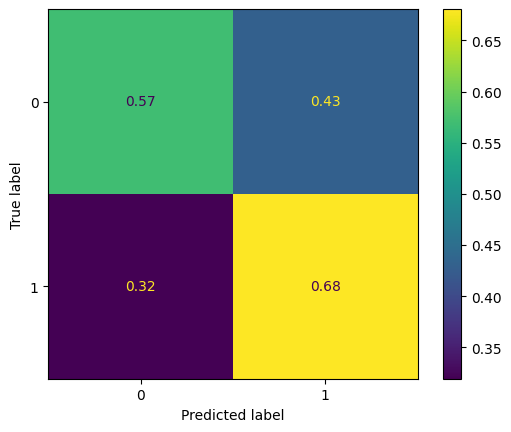

In [39]:
get_confusion_matrix(y_val, y_pred_val)

In [40]:
print(classification_report(y_val, y_pred_val, digits=4))

              precision    recall  f1-score   support

           0     0.6386    0.5704    0.6026     14920
           1     0.6156    0.6806    0.6465     15080

    accuracy                         0.6258     30000
   macro avg     0.6271    0.6255    0.6246     30000
weighted avg     0.6271    0.6258    0.6247     30000



### The Most Important Features

The idea here was to extract the most important features.
When there were too many features, it made the decison making process difficult for the model. It increased the training time as well. So instead, the most important features would be extracted based on output of the previous model, which would then be fed to another model for training. This would make the decision making process easier for the model.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


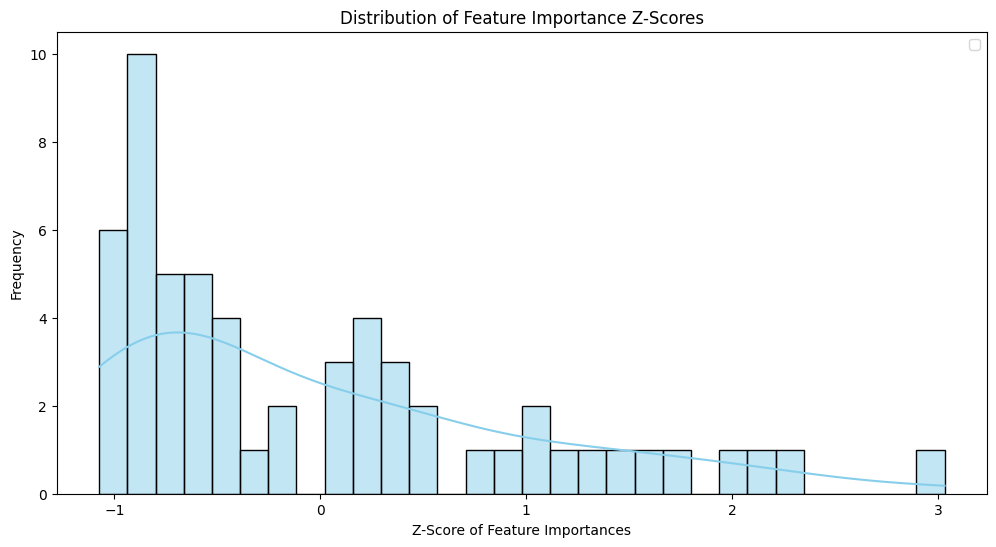

In [41]:
# Converting X_train_var back to DataFrame with original selected feature names
selected_features = X_train_extended.columns[var_thresh.get_support()]
X_train_var_df = pd.DataFrame(X_train_var, columns=selected_features)

# Computing feature importances
feature_importances = best_model.feature_importances_

# Creating a DataFrame with feature importances
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Computing Z-score of feature importances
feature_importance_df['Z-Score'] = zscore(feature_importance_df['Importance'])

# Plot the Z-scores
plt.figure(figsize=(12, 6))
sns.histplot(feature_importance_df['Z-Score'], bins = 30, kde=True, color="skyblue")
plt.xlabel("Z-Score of Feature Importances")
plt.ylabel("Frequency")
plt.title("Distribution of Feature Importance Z-Scores")
plt.legend()
plt.show()

In [42]:
# Setting a threshold for significance (|Z-score| > 0.842 for 60% confidence)
z_threshold = 0.842
important_features = feature_importance_df[np.abs(feature_importance_df['Z-Score']) > z_threshold]['Feature'].values

# Creating new datasets with significant features
X_train_selected = X_train_var_df[important_features]
X_test_selected = pd.DataFrame(X_test_var, columns=selected_features)[important_features]

print("New X_train shape:", X_train_selected.shape)
print("New X_test shape:", X_test_selected.shape)

New X_train shape: (100000, 24)
New X_test shape: (10000, 24)


### An experiment using the most important features

In [43]:
# Spliting data into training and validation sets
X_train_model, X_val, y_train_model, y_val = train_test_split(X_train_selected, y_train, test_size = 0.3, random_state=42)

# Initializing RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Defining the parameter grid for RandomizedSearchCV
param_dict = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 50],  
    'min_samples_split': [25, 30, 35],  
    'min_samples_leaf': [4, 6, 8, 10, 12]
}
# Implementing RandomizedSearchCV
random_search_1_b = RandomizedSearchCV(rf, param_dict, scoring='accuracy', cv=5, n_jobs=-1, random_state=42, verbose=1)

# Training the model
random_search_1_b.fit(X_train_model, y_train_model)
print("Best Parameters:", random_search_1_b.best_params_)

# Best model
best_model = random_search_1_b.best_estimator_

# Making predictions
y_pred_val = best_model.predict(X_val)
y_pred_train = best_model.predict(X_train_model)

# Evaluating accuracy
rf_val_accuracy_b = accuracy_score(y_val, y_pred_val)
rf_train_accuracy = accuracy_score(y_train_model, y_pred_train)

print("Train Accuracy: ", rf_train_accuracy)
print("Validation Accuracy:", rf_val_accuracy_b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 30, 'min_samples_leaf': 12, 'max_depth': 20}
Train Accuracy:  0.6894857142857143
Validation Accuracy: 0.6094


In [44]:
if rf_val_accuracy_a > rf_val_accuracy_b:
    rf_val_accuracy = rf_val_accuracy_a
    random_search_1 = random_search_1_a
    first_model = True
else:
    rf_val_accuracy = rf_val_accuracy_b
    random_search_1 = random_search_1_b
    first_model = False

## Classification Model 2 (XGBoost Classifier)

In [45]:
# Define XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', tree_method='hist')

# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform Randomized Search
random_search_2 = RandomizedSearchCV(xgb, param_dist, cv=5, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)

# Training the Model
random_search_2.fit(X_train_model, y_train_model)
print("Best Parameters:", random_search_2.best_params_)

# Best Model
best_xgb_model = random_search_2.best_estimator_

# Predictions
y_pred_val_xgb = best_xgb_model.predict(X_val)
xgb_val_accuracy = accuracy_score(y_val, y_pred_val_xgb)
print(f"Validation Accuracy : {xgb_val_accuracy:.4f}")

y_pred_train_xgb = best_xgb_model.predict(X_train_model)
xgb_train_accuracy = accuracy_score(y_train_model, y_pred_train_xgb)
print(f"Training Accuracy : {xgb_train_accuracy:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Validation Accuracy : 0.6106
Training Accuracy : 0.6886


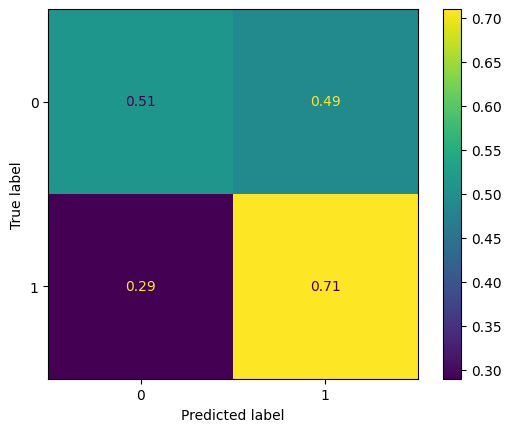

In [46]:
get_confusion_matrix(y_val, y_pred_val_xgb)

In [47]:
print(classification_report(y_val, y_pred_val_xgb))

              precision    recall  f1-score   support

           0       0.64      0.51      0.57     14920
           1       0.59      0.71      0.65     15080

    accuracy                           0.61     30000
   macro avg       0.61      0.61      0.61     30000
weighted avg       0.61      0.61      0.61     30000



## Classification Model 3 (LightGBM)

In [48]:
# Spliting data into training and validation sets
X_train_model, X_val, y_train_model, y_val = train_test_split(X_train_var, y_train, test_size = 0.3, random_state=42)

# Define parameter grid for LightGBM
param_dict = {
    'num_leaves': np.arange(10, 200, 20),
    'learning_rate': np.logspace(-3, 0, 10),
    'n_estimators': np.arange(50, 500, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.logspace(-4, 1, 10),
    'reg_lambda': np.logspace(-4, 1, 10)
}

# Initialize LightGBM classifier
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', random_state=42)

# Perform Randomized Search
random_search_3 = RandomizedSearchCV(
    lgb_clf, 
    param_distributions=param_dict, 
    cv=3, 
    scoring='accuracy', 
    random_state=42, 
    n_iter=50,
    n_jobs=-1
)

random_search_3.fit(X_train_model, y_train_model)
print("Best Parameters:", random_search_3.best_params_)

# Train the Best Model
best_lgb_model = random_search_3.best_estimator_

# Predictions
y_val_pred = best_lgb_model.predict(X_val)
lgb_val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {lgb_val_accuracy:.4f}")

y_train_pred = best_lgb_model.predict(X_train_model)
lgb_train_accuracy = accuracy_score(y_train_model, y_train_pred)
print(f"Training Accuracy: {lgb_train_accuracy:.4f}")

[LightGBM] [Info] Number of positive: 35445, number of negative: 34555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3793
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506357 -> initscore=0.025430
[LightGBM] [Info] Start training from score 0.025430
Best Parameters: {'subsample': 0.9, 'reg_lambda': 2.782559402207126, 'reg_alpha': 0.001291549665014884, 'num_leaves': 130, 'n_estimators': 200, 'learning_rate': 0.021544346900318832, 'colsample_bytree': 0.7}
Validation Accuracy: 0.6289
Training Accuracy: 0.6986


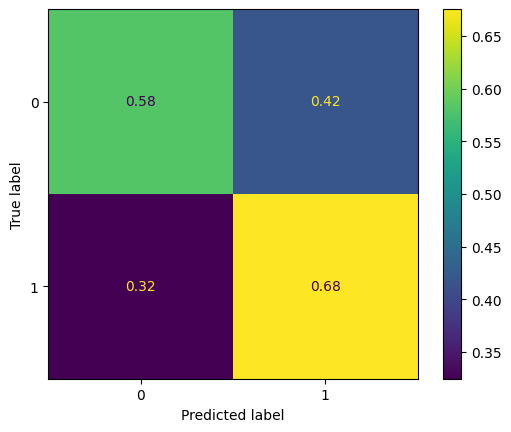

In [49]:
get_confusion_matrix(y_val, y_val_pred)

In [50]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61     14920
           1       0.62      0.68      0.65     15080

    accuracy                           0.63     30000
   macro avg       0.63      0.63      0.63     30000
weighted avg       0.63      0.63      0.63     30000



## Final Model

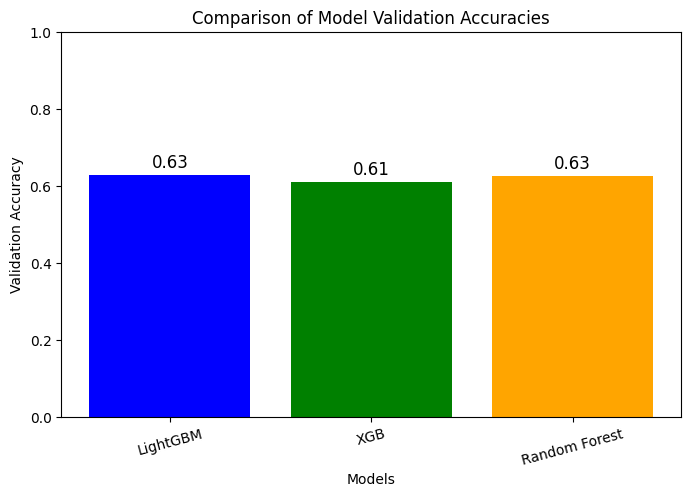

In [51]:
# Model names and their respective validation accuracies
models = ['LightGBM', 'XGB', 'Random Forest']
accuracies = [lgb_val_accuracy, xgb_val_accuracy, rf_val_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Labels and title to make the chart understandable
plt.ylabel("Validation Accuracy")
plt.xlabel("Models")
plt.title("Comparison of Model Validation Accuracies")
plt.ylim(0, 1) 
plt.xticks(rotation=15)

# Display accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

plt.show()

In [52]:
if max(rf_val_accuracy, xgb_val_accuracy, lgb_val_accuracy) == rf_val_accuracy:
    print('Using Random Forest as final model')

elif max(xgb_val_accuracy, lgb_val_accuracy) == xgb_val_accuracy:
    print('Using XGBoost as final model')
    
else:
    print('Using LightGBM as final model')

Using LightGBM as final model


Since LightGBM is working the best, I would try to train it on whole of the dataset to see if it works well.

In [53]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=42, **random_search_3.best_params_)
model.fit(X_train_var, y_train)
y_test = model.predict(X_test_var)

[LightGBM] [Info] Number of positive: 50525, number of negative: 49475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3855
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001


### Submission

In [54]:
# Creating a DataFrame for the results
result = pd.DataFrame({  
    'id': X_test.index, 
    'target': y_test
})

# Saving result to CSV
result.to_csv('submission.csv', index=False)